# Installation
* pip install numba 
* conda install numba

# Background
* Numba was initially developed to optimize the inefficient use-cases of [Numpy](https://numpy.org).
* Numpy uses multi-dimensional array (ndarray) object to store data.
* Python operators on ndarrays will trigger operations that are implemented in C and this is very efficient.
* Before Numba, NumPy users had to write Python C extensions to implement any custom computation in an efficient way. 


* Numba is a **function-at-a-time** Just-in-Time **(JIT)** compiler for CPython.
* Numba lets users annotate a **compute-intensive** Python function for compilation without rewriting the code in a low-level language like C.

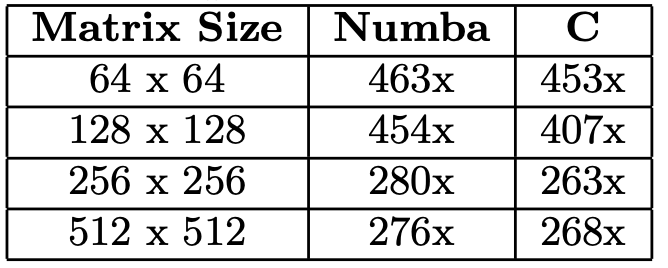

* [Lam, Siu Kwan et al. “Numba: a LLVM-based Python JIT compiler.” LLVM '15 (2015).](https://dl.acm.org/doi/pdf/10.1145/2833157.2833162)

## JIT Compiler
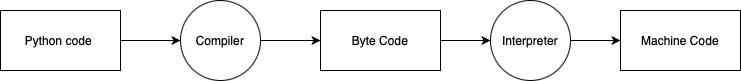



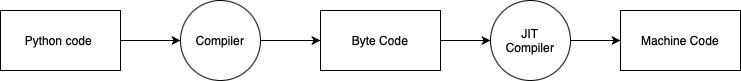

* Compiling happens at runtime (Just in time)
* Not ahead of time (AOT) like in C

## How does Numba work

* The programmer adds a Numba [decorator](https://www.datacamp.com/tutorial/decorators-python) to the function. 
* The decorator replaces the original Python function with a special object that just-in-time compiles the function when it is called the first time.

In [17]:
import numba
from numba import jit, int32, prange, vectorize, float64, cuda
import numpy as np
import math


* Decorating the function with @jit will mark a function for optimization by Numba’s JIT compiler
* The compilation will be deferred until the first function execution
* different function invocation will result in different compilation

In [3]:
@jit
def f(x, y):
    return x + y

<ipython-input-3-6317aad7f382>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def f(x, y):


In [4]:
print(f(2, 3)) # This generates one compiled code

5


In [5]:
# we can see what LLVM is doing with the function
for k, v in f.inspect_llvm().items():
    print(k, v)

(int64, int64) ; ModuleID = 'f'
source_filename = "<string>"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

@.const.f = internal constant [2 x i8] c"f\00"
@_ZN08NumbaEnv8__main__1fB2v1B44c8tJTIcFKzyF2ILShI4CWgLCLoquCRgiYJYmAA_3d_3dExx = common local_unnamed_addr global i8* null
@".const.missing Environment: _ZN08NumbaEnv8__main__1fB2v1B44c8tJTIcFKzyF2ILShI4CWgLCLoquCRgiYJYmAA_3d_3dExx" = internal constant [100 x i8] c"missing Environment: _ZN08NumbaEnv8__main__1fB2v1B44c8tJTIcFKzyF2ILShI4CWgLCLoquCRgiYJYmAA_3d_3dExx\00"
@PyExc_RuntimeError = external global i8

; Function Attrs: mustprogress nofree norecurse nosync nounwind willreturn writeonly
define i32 @_ZN8__main__1fB2v1B44c8tJTIcFKzyF2ILShI4CWgLCLoquCRgiYJYmAA_3d_3dExx(i64* noalias nocapture writeonly %retptr, { i8*, i32, i8*, i8*, i32 }** noalias nocapture readnone %excinfo, i64 %arg.x, i64 %arg.y) local_unnamed_addr #0 {
entry:
  %.6 = add 

In [6]:
print(f('2', '3')) # This generates another compiled code

23


* We can tell numba to generated code only for one set of arguments

In [7]:
@jit(int32(int32, int32))
def f_1(x, y):
    return x + y

<ipython-input-7-789ed2ba1aaf>:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int32(int32, int32))


In [8]:
print(f_1(2, 3))

5


In [9]:
print(f_1('2', '3')) # generates error

TypeError: No matching definition for argument type(s) unicode_type, unicode_type

* one compiled function can call another compiled function

In [10]:
@jit
def square(x):
    return x ** 2

@jit
def hypot(x, y):
    return math.sqrt(square(x) + square(y))

<ipython-input-10-2003debfec3f>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def square(x):
<ipython-input-10-2003debfec3f>:6: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hypot(x, y):


In [11]:
print(hypot(4, 3))

5.0


# Performance

In [12]:

x = np.arange(100).reshape(10, 10)

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def without_numba(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting



In [54]:
%%time
print(without_numba(x))

[[  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.]
 [ 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.]
 [ 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.]
 [ 39.  40.  41.  42.  43.  44.  45.  46.  47.  48.]
 [ 49.  50.  51.  52.  53.  54.  55.  56.  57.  58.]
 [ 59.  60.  61.  62.  63.  64.  65.  66.  67.  68.]
 [ 69.  70.  71.  72.  73.  74.  75.  76.  77.  78.]
 [ 79.  80.  81.  82.  83.  84.  85.  86.  87.  88.]
 [ 89.  90.  91.  92.  93.  94.  95.  96.  97.  98.]
 [ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108.]]
CPU times: user 213 ms, sys: 6.49 ms, total: 220 ms
Wall time: 224 ms


In [55]:
x = np.arange(100).reshape(10, 10)


def with_numba(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting



In [56]:
%%time
print(with_numba(x))

[[  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.]
 [ 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.]
 [ 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.]
 [ 39.  40.  41.  42.  43.  44.  45.  46.  47.  48.]
 [ 49.  50.  51.  52.  53.  54.  55.  56.  57.  58.]
 [ 59.  60.  61.  62.  63.  64.  65.  66.  67.  68.]
 [ 69.  70.  71.  72.  73.  74.  75.  76.  77.  78.]
 [ 79.  80.  81.  82.  83.  84.  85.  86.  87.  88.]
 [ 89.  90.  91.  92.  93.  94.  95.  96.  97.  98.]
 [ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108.]]
CPU times: user 1.69 ms, sys: 149 µs, total: 1.84 ms
Wall time: 2.1 ms


In [57]:
%%time
print(with_numba(x))


[[  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.]
 [ 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.]
 [ 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.]
 [ 39.  40.  41.  42.  43.  44.  45.  46.  47.  48.]
 [ 49.  50.  51.  52.  53.  54.  55.  56.  57.  58.]
 [ 59.  60.  61.  62.  63.  64.  65.  66.  67.  68.]
 [ 69.  70.  71.  72.  73.  74.  75.  76.  77.  78.]
 [ 79.  80.  81.  82.  83.  84.  85.  86.  87.  88.]
 [ 89.  90.  91.  92.  93.  94.  95.  96.  97.  98.]
 [ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108.]]
CPU times: user 1.56 ms, sys: 186 µs, total: 1.75 ms
Wall time: 1.78 ms


# Compilation options

* nopython mode - compilation without using Puthon C API (faster).
    * Numba should use types known to Numba.
* object mode - compilation using Puthon C API (slower).
* If nopython mode fail numba will automatically fallback to object mode.
* so its a good practice to compile everything in nopython mode  

In [37]:
# nopython=True will force numba not to fallback to the object mode. 
# This will force an error if type inference does not work

@jit(nopython=True)
def f(x, y):
    return x + y

In [58]:
# When numba compiled a code operates only on the native types.
# So it is not necessary to hold the GIL

@jit(nogil=True)
def f(x, y):
    return x + y

# beware: This can cause syncronization issues

In [ ]:
# The chances are you call the same function again and again with the same argument type
# So you can cached the compiled code. 

@jit(cache=True)
def f(x, y):
    return x + y

In [59]:
#automatic parallelization

@jit(nopython=True, parallel=True)
def f(x, y):
    return x + y

In [71]:
@jit(nopython=True)
def reduction_without_parallel(n):
    shp = (13, 17)
    result1 = 2 * np.ones(shp, np.int_)
    tmp = 2 * np.ones_like(result1)

    for i in prange(n):
        result1 *= tmp

    return result1

In [72]:
%%time 
reduction_without_parallel(10)

CPU times: user 342 ms, sys: 11.7 ms, total: 354 ms
Wall time: 362 ms


array([[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048

In [73]:
@jit(nopython=True, parallel=True)
def reduction_with_parallel(n):
    shp = (13, 17)
    result1 = 2 * np.ones(shp, np.int_)
    tmp = 2 * np.ones_like(result1)

    for i in prange(n):
        result1 *= tmp

    return result1

In [74]:
%%time 
reduction_with_parallel(10)

CPU times: user 2.04 s, sys: 32.9 ms, total: 2.07 s
Wall time: 2.12 s


array([[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
        2048, 2048, 2048, 2048, 2048, 2048],
       [2048, 2048, 2048, 2048, 2048, 2048, 2048

In [ ]:
%%time 
reduction_without_parallel(10000000)

In [79]:
%%time 
reduction_with_parallel(10000000)

CPU times: user 3.86 s, sys: 13.3 ms, total: 3.87 s
Wall time: 1.09 s


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

* In NumPy universal function (ufunc) is a function that operates on ndarrays in an element-by-element fashion

In [83]:
x = [1, 2, 3, 4]
y = [4, 5, 6, 7]
z = np.add(x, y)

print(z)

[ 5  7  9 11]


* Creating a ufunc that operates on a ndarray of a prticular type is not traught forward

In [127]:
def sinacosb(a, b):
    return math.sin(a) * math.cos(b)
    

In [128]:
n = 10000000
a = np.ones(n, dtype=np.dtype('f8'))
b = 2*a

In [129]:
sinacosb(a, b)

TypeError: only size-1 arrays can be converted to Python scalars

In [131]:
#Numba makes this process easy 

@vectorize([float64(float64, float64)]) 
def sinacosb_vect(a, b):
    return math.sin(a) * math.cos(b)
     

In [132]:
sinacosb_vect(a, b)

array([-0.35017549, -0.35017549, -0.35017549, ..., -0.35017549,
       -0.35017549, -0.35017549])

# CUDA 
* pip install cudatoolkit
* Usual cuda operation in C/C++
    * Move data from host memory from host to device memory.
    * Launch the kernel with correct grid dimension.
    * Execute kernel on the device.
    * Move data from device memory to host memory.

In [15]:
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y


In [19]:
x = [1, 2, 3, 4]
y = [4, 5, 6, 7]
add_ufunc(x, y)

/home/joseph/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 5,  7,  9, 11])

Numba automates the following:

* Allcated GPU memory.
* Copy data to the GPU memory.
* Executed the CUDA kernel with the *correct kernel dimensions given the input sizes*.
* Copy data to the hist memory.
* Return the result as a NumPy array. 

* We can also create normal function that are called from a vectorized fucntion
* Using cuda.jit

In [20]:
@cuda.jit(device=True) #This function will only be executed on a GPU
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y  

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5


In [28]:
x = np.arange(100, dtype='float32').reshape(1, 100)
polar_distance(x, x, x, x)

/home/joseph/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.2013700e-07,
        0.0000000e+00, 2.9802322e-08, 0.0000000e+00, 2.1490760e-07,
        0.0000000e+00, 1.8848644e-07, 1.6858739e-07, 2.3842040e-07,
        0.0000000e+00, 2.7476383e-07, 2.3841858e-07, 5.3312016e-07,
        0.0000000e+00, 6.7959752e-07, 5.9604645e-07, 7.7843413e-07,
        2.3841858e-07, 9.5553514e-07, 5.9604935e-07, 4.2146849e-07,
        4.7683716e-07, 4.9151248e-07, 1.1920929e-06, 4.2981520e-07,
        3.3717478e-07, 5.1273855e-07, 5.3312016e-07, 8.5340866e-07,
        0.0000000e+00, 1.4901397e-06, 1.1801118e-06, 2.5288108e-07,
        1.9110703e-06, 8.3659103e-07, 1.7970578e-06, 1.1876141e-06,
        4.7683716e-07, 1.6801348e-06, 9.5367432e-07, 5.6230908e-07,
        1.6690798e-06, 1.2287812e-06, 1.1980385e-06, 1.7377591e-06,
        9.5367432e-07, 1.6858739e-07, 6.3360608e-07, 1.7721735e-06,
        3.5762787e-07, 1.5557270e-06, 2.6656008e-07, 1.1921060e-06,
        1.3486991e-06, 9.5040912e-07, 1.3134171e

# Limitation

In [133]:
@jit
def cannot_compile(x): #  Numba will fall back to a mode, called "object mode
    return x['key']

cannot_compile(dict(key='value'))

/var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_13066/391980188.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cannot_compile" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_13066/391980188.py (3)

File "../../../../../var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_13066/391980188.py", line 3:
<source missing, REPL/exec in use?>

  @jit
/usr/local/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cannot_compile" was compiled in object mode without forceobj=True.

File "../../../../../var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_13066/391980188.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/usr/local/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the

'value'

In [134]:
@jit(nopython=True)
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_13066/2364033852.py (3)

File "../../../../../var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/ipykernel_13066/2364033852.py", line 3:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'dict'>
